In [828]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,TensorDataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

In [829]:
data = pd.read_csv('car_price.csv')

In [830]:
data.drop(data.columns[[0,1]], axis= 1, inplace=True)

In [831]:
data

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats
...,...,...,...,...,...,...,...,...
5507,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats


In [832]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   car_prices_in_rupee  5512 non-null   object
 1   kms_driven           5512 non-null   object
 2   fuel_type            5512 non-null   object
 3   transmission         5512 non-null   object
 4   ownership            5512 non-null   object
 5   manufacture          5512 non-null   int64 
 6   engine               5512 non-null   object
 7   Seats                5512 non-null   object
dtypes: int64(1), object(7)
memory usage: 344.6+ KB


In [833]:
def convert_to_float(value):
    if "kms" in value:
        return float(value.replace('kms', '').replace(',', '').strip())
    elif "cc" in value:
         return float(value.replace('cc', '').strip())
    elif 'Seat' in value:
            return float(value.split()[0])

In [834]:
def convert_car_price (value):
    if "Lakh" in value:
        return float(value.replace('Lakh', '').strip()) * 1e5
    
    elif "Crore" in value:
        return float(value.replace('Crore', '').strip()) * 1e7
    
    elif ',' in value: 
        return float(value.replace(',', ''))

In [835]:
data

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats
...,...,...,...,...,...,...,...,...
5507,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats


In [836]:
data['kms_driven'] = data['kms_driven'].apply(convert_to_float)
data['engine'] = data['engine'].apply(convert_to_float)
data['Seats'] = data['Seats'].apply(convert_to_float)

data['car_prices_in_rupee'] = data['car_prices_in_rupee'].apply(convert_car_price)

In [837]:
data

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,1003000.0,86226.0,Diesel,Manual,1st Owner,2017,1956.0,5.0
1,1283000.0,13248.0,Petrol,Automatic,1st Owner,2021,1330.0,5.0
2,1640000.0,60343.0,Petrol,Automatic,1st Owner,2016,2494.0,5.0
3,777000.0,26696.0,Petrol,Automatic,1st Owner,2018,1199.0,5.0
4,515000.0,69414.0,Petrol,Manual,1st Owner,2016,1199.0,5.0
...,...,...,...,...,...,...,...,...
5507,2890000.0,45000.0,Diesel,Automatic,1st Owner,2018,2995.0,7.0
5508,6490000.0,29000.0,Petrol,Automatic,2nd Owner,2015,1968.0,5.0
5509,1375000.0,90000.0,Diesel,Automatic,2nd Owner,2013,2755.0,5.0
5510,2990000.0,79000.0,Diesel,Automatic,3rd Owner,2015,2967.0,6.0


In [838]:
data.ownership.unique()

array(['1st Owner', '2nd Owner', '3rd Owner', '4th Owner', '5th Owner',
       '0th Owner'], dtype=object)

In [839]:
mapping = {
    '0th Owner':6.0,
    '1st Owner':5.0, 
    '2nd Owner':4.0, 
    '3rd Owner':3.0, 
    '4th Owner':2.0, 
    '5th Owner':1.0,
}

In [840]:
data['ownership'] = data['ownership'].map(mapping)

In [841]:
data['transmission'] = data['transmission'].map({'Manual':1.0, 'Automatic':2.0})

In [842]:
data['fuel_type'].value_counts()

fuel_type
Petrol      2967
Diesel      2423
Cng           80
Lpg           28
Electric      14
Name: count, dtype: int64

In [843]:
mean_fuel_price = data.groupby('fuel_type')["car_prices_in_rupee"].mean()

<BarContainer object of 5 artists>

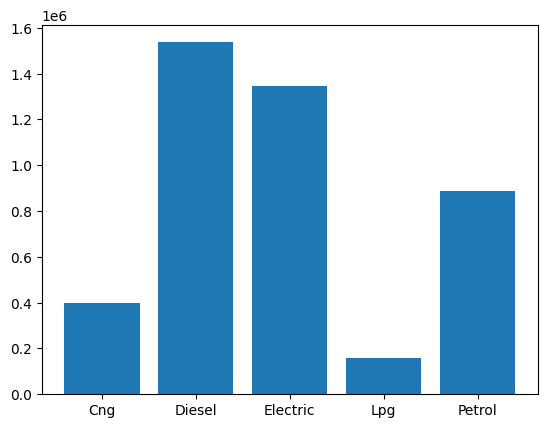

In [844]:
plt.bar(x =mean_fuel_price.index,height=mean_fuel_price.values)

In [845]:
fuel_map = {
    'Lpg' : 1.0,
    'Cng' : 2.0,
    'Petrol' : 3.0,
    'Electric' : 4.0,
    'Diesel' : 4.0   
}

In [846]:
data['fuel_type'] = data['fuel_type'].map(fuel_map)

In [847]:
data.isnull().sum().sum()

0

In [848]:
data

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,1003000.0,86226.0,4.0,1.0,5.0,2017,1956.0,5.0
1,1283000.0,13248.0,3.0,2.0,5.0,2021,1330.0,5.0
2,1640000.0,60343.0,3.0,2.0,5.0,2016,2494.0,5.0
3,777000.0,26696.0,3.0,2.0,5.0,2018,1199.0,5.0
4,515000.0,69414.0,3.0,1.0,5.0,2016,1199.0,5.0
...,...,...,...,...,...,...,...,...
5507,2890000.0,45000.0,4.0,2.0,5.0,2018,2995.0,7.0
5508,6490000.0,29000.0,3.0,2.0,4.0,2015,1968.0,5.0
5509,1375000.0,90000.0,4.0,2.0,4.0,2013,2755.0,5.0
5510,2990000.0,79000.0,4.0,2.0,3.0,2015,2967.0,6.0


In [849]:
scaler = MinMaxScaler()

In [850]:
data_scaled = scaler.fit_transform(data)

In [851]:
data_scaled

array([[0.05050874, 0.15359714, 1.        , ..., 0.81481481, 0.3287395 ,
        0.5       ],
       [0.06511871, 0.02322108, 0.66666667, ..., 0.96296296, 0.22352941,
        0.5       ],
       [0.08374641, 0.10735686, 0.66666667, ..., 0.77777778, 0.41915966,
        0.5       ],
       ...,
       [0.06991912, 0.16033944, 1.        , ..., 0.66666667, 0.46302521,
        0.5       ],
       [0.15418732, 0.14068781, 1.        , ..., 0.74074074, 0.49865546,
        0.66666667],
       [0.16462301, 0.07458687, 1.        , ..., 0.81481481, 0.33462185,
        0.5       ]])

In [852]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled[..., 1:], data_scaled[...,0], test_size =0.2, shuffle=True)

In [853]:
print(X_train.shape,y_train.shape)

(4409, 7) (4409,)


In [854]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [855]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [856]:
train_dataset = TensorDataset(X_train, y_train)

In [857]:
test_dataset = TensorDataset(X_test, y_test)

In [858]:
train_dl = DataLoader(train_dataset, batch_size = 64)
test_dl = DataLoader(test_dataset, batch_size=64, drop_last=False)

In [859]:
class RegressionNet (nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self,x):
        return self.layers(x)

In [860]:
input_size = len(X_train[0])

In [861]:
model = RegressionNet(input_size)

In [862]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [863]:
num_epochs = 100

In [864]:
train_losses = []
test_losses = []

In [865]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)



    epoch_loss = running_loss / len(train_dl.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/100, Loss: 0.0086
Epoch 2/100, Loss: 0.0074
Epoch 3/100, Loss: 0.0072
Epoch 4/100, Loss: 0.0066
Epoch 5/100, Loss: 0.0065
Epoch 6/100, Loss: 0.0065
Epoch 7/100, Loss: 0.0063
Epoch 8/100, Loss: 0.0065
Epoch 9/100, Loss: 0.0062
Epoch 10/100, Loss: 0.0063
Epoch 11/100, Loss: 0.0063
Epoch 12/100, Loss: 0.0062
Epoch 13/100, Loss: 0.0062
Epoch 14/100, Loss: 0.0062
Epoch 15/100, Loss: 0.0064
Epoch 16/100, Loss: 0.0061
Epoch 17/100, Loss: 0.0062
Epoch 18/100, Loss: 0.0062
Epoch 19/100, Loss: 0.0062
Epoch 20/100, Loss: 0.0061
Epoch 21/100, Loss: 0.0062
Epoch 22/100, Loss: 0.0060
Epoch 23/100, Loss: 0.0062
Epoch 24/100, Loss: 0.0061
Epoch 25/100, Loss: 0.0061
Epoch 26/100, Loss: 0.0060
Epoch 27/100, Loss: 0.0061
Epoch 28/100, Loss: 0.0059
Epoch 29/100, Loss: 0.0060
Epoch 30/100, Loss: 0.0061
Epoch 31/100, Loss: 0.0059
Epoch 32/100, Loss: 0.0060
Epoch 33/100, Loss: 0.0061
Epoch 34/100, Loss: 0.0059
Epoch 35/100, Loss: 0.0059
Epoch 36/100, Loss: 0.0062
Epoch 37/100, Loss: 0.0059
Epoch 38/1

In [866]:
model.eval();

In [867]:
with torch.no_grad():
    for test_inputs, test_targets in test_dl:
        predictions = model(test_inputs)
    
        test_inputs_np = test_inputs.numpy()
        test_targets_np = test_targets.numpy()
        predictions_np = predictions.numpy()
        

        dummy_data = np.zeros((len(test_inputs_np), data_scaled.shape[1]))
        dummy_data[..., 1:] = test_inputs_np
        dummy_data[..., 0] = predictions_np.flatten()
        

        original_scale = scaler.inverse_transform(dummy_data)
        predicted_prices = original_scale[:, 0]
        actual_prices = scaler.inverse_transform(np.column_stack((test_targets_np, test_inputs_np)))[:, 0]

In [868]:
mse = mean_squared_error(actual_prices,predicted_prices)
r2 = r2_score(actual_prices,predicted_prices)

In [869]:
print(f"MSE = {mse}, r2 = {r2}")

MSE = 808004498636.4822, r2 = 0.3115063509631977


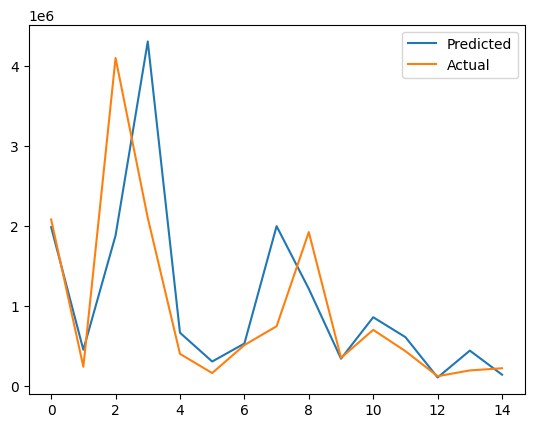

In [870]:
plt.plot(predicted_prices, label = 'Predicted')
plt.plot(actual_prices, label = 'Actual')
plt.legend()
plt.show()